In [1]:
from pytorch_lightning import Trainer
import active_catinous.FastGramDynamicMemoryLungNodule as lungmodel
from active_catinous.FastGramDynamicMemoryLungNodule import FastGramDynamicMemoryLungNodule
from datasets.LIDCDataset import LIDCDataset
from datasets.LIDCDatasetContinuous import LIDCDatasetContinuous

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
#import seaborn as sns
import pickle
from py_jotools import slurm, cache
import numpy as np
import gc
#from evalscript import eval_testset, eval_forbwtfwt

import hashlib
import dill
import active_catinous.utils as cutils

from sklearn.metrics import mean_absolute_error

from models.AgePredictor import EncoderRegressor
from models.unet3d import EncoderModelGenesis

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
from glob import glob
import datetime 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%load_ext autoreload
%autoreload 

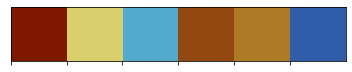

In [2]:
mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
#colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[20], cm_data[45], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())

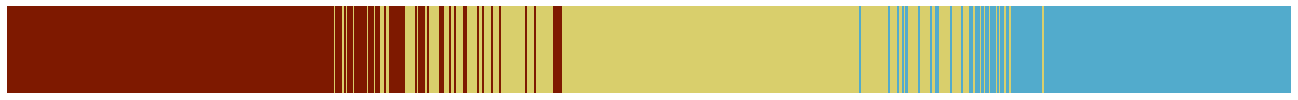

In [3]:
ds = LIDCDatasetContinuous('/project/catinous/lunadata/luna_lunacombined_dataset.csv', transition_phase_after=0.7, seed=2314134)
scan = ds.df.res == 'geb'
scan[ds.df.res == 'sie'] = 2

plt.figure(figsize=(50,1.5))
plt.imshow(np.tile(scan,(50,1)), cmap=ListedColormap(colormap.colors[:3]))
plt.axis('off')
plt.tight_layout()

In [2]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not lungmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)    
        else:
            _, df_temp, _, _ = lungmodel.trained_model(base_params[-1], train=False)
            df_temp = df_temp.loc[df_temp['val_map_ges']==df_temp['val_map_ges']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

In [3]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
         'base_model': 'ln_batch_luna_lunacombined_dataset_malignancy_base_train_1_9ee74b86a3.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'len_perf_queue': 8,
         'transition_phase_after':0.7,
        'memorymaximum': 64,
        'completion_limit': 0.6,
         'random_cache': True,
         'startbudget': 150,
         'allowedlabelratio': 0
        }

df_res = res_data_for_params(hparams)

reading settings from hparams
init
init task model
read base model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_cont_luna_lunacombined_dataset_malignancy_basemodel_batch_fmiss_memory_tf07_1_186e38666a.pt
Read: /project/catinous/active_catinous/trained_models/ln_cont_luna_lunacombined_dataset_malignancy_basemodel_batch_fmiss_memory_tf07_1_186e38666a.pt
not cached
not cached
not cached
not cached


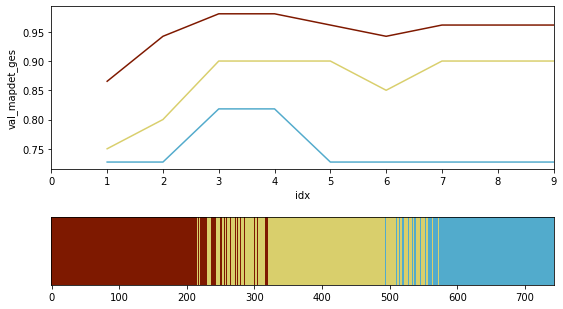

In [31]:
fig, ax = plt.subplots(2,1, figsize=(9, 6))
plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_res, y='val_mapdet_ges', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_res, y='val_mapdet_geb', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_res, y='val_mapdet_sie', x='idx', ax=ax[0], err_style=None)

ax[0].set_xlim(0, 9)

ax[1].imshow(np.tile(scan,(100,1)), cmap=ListedColormap(colormap.colors[:3]), alpha=1.0)
ax[1].get_yaxis().set_visible(False)
ax[1].get_yaxis()


In [5]:
def test_model(hparams):
    model, logs, df_mem, expname = lungmodel.trained_model(hparams, train=False)
    model.eval()
    
    for res in ['ges', 'geb', 'sie']:
        ds_test = LIDCDataset('/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv', 
                      cropped_to=(288, 288), split=['val'], res=res, validation=True)

        device = torch.device('cuda')
        iou_thres = 0.2

        overall_true = 0
        overall_wrong = 0
        detected_count = 0
        not_detected_count = 0 

        for batch in ds_test:
            img_batch, annot, res, image = batch
            img_batch = img_batch.to(device)

            out = model.model(img_batch)
            out_boxes = [cutils.filter_boxes_area(out[i]['boxes'].cpu().detach().numpy(), out[i]['scores'].cpu().detach().numpy()) for i in range(len(out))]
            boxes_np = [b[0] for b in out_boxes]
            scores_np = [b[1] for b in out_boxes]

            final_boxes, final_scores = cutils.correct_boxes(boxes_np, scores_np)

            gt = annot['boxes'][0]
            true_pred = 0
            wrong_pred = 0
            detected = False

            if len(final_boxes)>0:
                for i, b in enumerate(final_boxes):
                    if final_scores[i]>0.5:
                        if cutils.bb_intersection_over_union(gt, b)>iou_thres:
                            true_pred+=1
                            detected = True
                        else:
                            wrong_pred+=1
                if detected:
                    detected_count += 1
                else:
                    not_detected_count += 1
            overall_true += true_pred
            overall_wrong += wrong_pred
        print(f'_____________{res}___________')
        print('detections: ', detected_count/(not_detected_count+detected_count))
        print('box predictions: ', overall_true/(overall_true+overall_wrong))
        print('fp/scan: ', overall_wrong/len(ds_test))

In [6]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
         'base_model': 'ln_batch_luna_lunacombined_dataset_malignancy_base_train_1_9ee74b86a3.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'len_perf_queue': 8,
         'transition_phase_after':0.7,
        'memorymaximum': 64,
        'completion_limit': 0.6,
         'random_cache': True,
         'startbudget': 150,
         'allowedlabelratio': 0
        }
test_model(hparams)

reading settings from hparams
init
init task model
read base model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_cont_luna_lunacombined_dataset_malignancy_basemodel_batch_fmiss_memory_tf07_1_186e38666a.pt
Read: /project/catinous/active_catinous/trained_models/ln_cont_luna_lunacombined_dataset_malignancy_basemodel_batch_fmiss_memory_tf07_1_186e38666a.pt
_____________ges___________
detections:  0.9615384615384616
box predictions:  0.43859649122807015
fp/scan:  1.2307692307692308
_____________geb___________
detections:  0.9
box predictions:  0.2647058823529412
fp/scan:  2.5
_____________sie___________
detections:  0.7272727272727273
box predictions:  0.2962962962962963
fp/scan:  1.7272727272727273


In [7]:
hparams={'continuous': False,
         'use_memory':False,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
        'val_check_interval': 100,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.0001,
         'noncontinuous_steps': 2000,
        'noncontinuous_train_splits': ['base_train'],
         'scanner': 'ges'
        }
test_model(hparams)

reading settings from hparams
init
init task model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train_1_9ee74b86a3.pt
Read: /project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train_1_9ee74b86a3.pt
_____________ges___________
detections:  0.8
box predictions:  0.6545454545454545
fp/scan:  0.36538461538461536
_____________geb___________
detections:  0.6
box predictions:  0.36363636363636365
fp/scan:  1.05
_____________sie___________
detections:  0.5454545454545454
box predictions:  0.42857142857142855
fp/scan:  0.7272727272727273


In [8]:
hparams={'continuous': False,
         'use_memory':False,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
        'val_check_interval': 100,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.0001,
         'noncontinuous_steps': 2000,
        'noncontinuous_train_splits': ['base_train', 'train'],
         'scanner': 'ges'
        }
test_model(hparams)

reading settings from hparams
init
init task model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_5888224fe3.pt
Read: /project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_5888224fe3.pt
_____________ges___________
detections:  0.74
box predictions:  0.6727272727272727
fp/scan:  0.34615384615384615
_____________geb___________
detections:  0.7368421052631579
box predictions:  0.4827586206896552
fp/scan:  0.75
_____________sie___________
detections:  0.6363636363636364
box predictions:  0.4375
fp/scan:  0.8181818181818182


In [9]:
hparams={'continuous': False,
         'use_memory':False,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
        'val_check_interval': 100,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.0001,
         'noncontinuous_steps': 2000,
        'noncontinuous_train_splits': ['base_train', 'train'],
         'scanner': 'geb'
        }
test_model(hparams)

reading settings from hparams
init
init task model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_1fbd21c367.pt
Read: /project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_1fbd21c367.pt
_____________ges___________
detections:  0.4878048780487805
box predictions:  0.5
fp/scan:  0.38461538461538464
_____________geb___________
detections:  0.35294117647058826
box predictions:  0.5
fp/scan:  0.3
_____________sie___________
detections:  0.6363636363636364
box predictions:  0.5
fp/scan:  0.6363636363636364


In [10]:
hparams={'continuous': False,
         'use_memory':False,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
        'val_check_interval': 100,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.0001,
         'noncontinuous_steps': 2000,
        'noncontinuous_train_splits': ['base_train', 'train'],
         'scanner': 'sie'
        }
test_model(hparams)

reading settings from hparams
init
init task model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_0decbc9c82.pt
Read: /project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_0decbc9c82.pt
_____________ges___________
detections:  0.5454545454545454
box predictions:  0.8
fp/scan:  0.057692307692307696
_____________geb___________
detections:  0.3333333333333333
box predictions:  0.5555555555555556
fp/scan:  0.2
_____________sie___________
detections:  0.7
box predictions:  0.7777777777777778
fp/scan:  0.18181818181818182


In [11]:
hparams={'continuous': False,
         'use_memory':False,
        'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
        'val_check_interval': 100,
        'run_postfix': 1,
        'batch_size': 4,
        'training_batch_size': 4,
         'learning_rate': 0.0001,
         'noncontinuous_steps': 2000,
        'noncontinuous_train_splits': ['base_train', 'train'],
        }
test_model(hparams)

reading settings from hparams
init
init task model
only validation, not training the model
/project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_bc5c55affa.pt
Read: /project/catinous/active_catinous/trained_models/ln_batch_luna_lunacombined_dataset_malignancy_base_train-train_1_bc5c55affa.pt
_____________ges___________
detections:  0.6923076923076923
box predictions:  0.5538461538461539
fp/scan:  0.5576923076923077
_____________geb___________
detections:  0.6
box predictions:  0.4
fp/scan:  0.9
_____________sie___________
detections:  0.6363636363636364
box predictions:  0.2916666666666667
fp/scan:  1.5454545454545454
